In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
import scipy.sparse as sp

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.decomposition import TruncatedSVD

import time
from datetime import datetime

from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

import pickle
import joblib
import os

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
sns.set(style="whitegrid")

# Load and Explore Dataset

In [3]:
try:
    train_df = pd.read_csv('Dataset/train.csv')
    test_df = pd.read_csv('Dataset/test.csv')

    print(f"training data shape: {train_df.shape}")
    print(f"test data shape: {test_df.shape}")
except FileNotFoundError as e:
    print("please ensure 'train.csv' and 'test.csv' are in the correct directory")

training data shape: (120000, 3)
test data shape: (7600, 3)


In [4]:
print("training data info:")
print(train_df.info())

print("\ntest data info:")
print(test_df.info())

print(f"\ntraining columns: {list(train_df.columns)}")
print(f"\ntest columns: {list(test_df.columns)}")

training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
None

test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB
None

training columns: ['Class Index', 'Title', 'Description']

test columns: ['Class Index', 'Title', 'Description']


In [5]:
print("first 3 rows of training data:")
print(train_df.head(3))

print("\nfirst 3 rows of test data:")
print(test_df.head(3))

first 3 rows of training data:
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  

first 3 rows of test data:
   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      Ky. Company Wins Grant to Study Peptides (AP)   

                                         Description  
0  Unions representing workers at Turner   Newall...  
1  SPACE.com - TORONTO, Canada -- A second\team o...  
2 

In [6]:
class_col = train_df.columns[0]
print(f"class distribution in training data (column: '{class_col}):")
class_counts = train_df[class_col].value_counts().sort_index()
print(class_counts)

class distribution in training data (column: 'Class Index):
Class Index
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64


In [7]:
class_mapping = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Sci/Tech'
}

print(f"class labels mapping:")
for class_id, class_name in class_mapping.items():
    count = class_counts.get(class_id, 0)
    print(f"{class_id} -> {class_name}: {count:,} samples")

class labels mapping:
1 -> World: 30,000 samples
2 -> Sports: 30,000 samples
3 -> Business: 30,000 samples
4 -> Sci/Tech: 30,000 samples


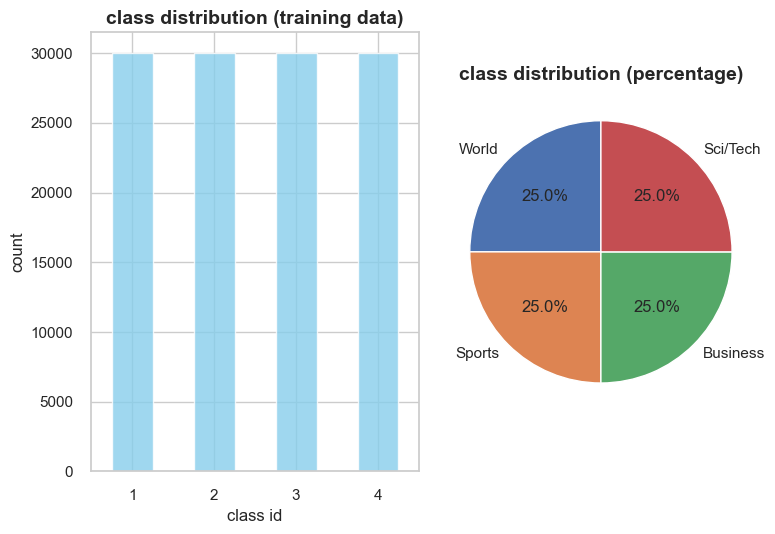

In [8]:
plt.Figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('class distribution (training data)', fontsize=14, fontweight='bold')
plt.xlabel('class id')
plt.ylabel('count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
class_names = [class_mapping[i] for i in class_counts.index]
plt.pie(class_counts.values, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('class distribution (percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
text_columns = [col for col in train_df.columns if col != class_col]
print(f"text columns: {text_columns}")

for col in text_columns[:2]:
    if col in train_df.columns:
        text_lengths = train_df[col].astype(str).apply(len)

        print(f"\naverage length: {text_lengths.mean():.1f} characters")
        print(f"median length: {text_lengths.median():.1f} characters")
        print(f"min length: {text_lengths.min():.1f} characters")
        print(f"max length: {text_lengths.max():.1f} characters")
        print(f"std deviation: {text_lengths.std():.1f} characters")

text columns: ['Title', 'Description']

average length: 42.1 characters
median length: 41.0 characters
min length: 6.0 characters
max length: 115.0 characters
std deviation: 13.6 characters

average length: 193.4 characters
median length: 188.0 characters
min length: 6.0 characters
max length: 985.0 characters
std deviation: 64.5 characters


In [10]:
print("missing values in training data:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "no missing values")

print("\nmissing values in test data:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0] if missing_test.sum() > 0 else "no missing values")

missing values in training data:
no missing values

missing values in test data:
no missing values


# Data Preprocessing and Text Cleaning

In [11]:
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except Exception as e:
    print(f"Warning: {e}")

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

additional_stopwords = {
    'reuters', 'ap', 'afp', 'said', 'says', 'new', 'news', 'report', 'reports',
    'according', 'sources', 'source', 'would', 'could', 'should', 'one', 'two',
    'also', 'get', 'go', 'make', 'take', 'come', 'see', 'know', 'think', 'say'
}
stop_words.update(additional_stopwords)

In [13]:
reverse_mapping = {
    'World': 1, 
    'Sports': 2, 
    'Business': 3, 
    'Sci/Tech': 4
}

train_df['Class_Name'] = train_df['Class Index'].map(class_mapping)
test_df['Class_Name'] = test_df['Class Index'].map(class_mapping)

In [14]:
def clean_text(text):
               if pd.isna(text) or text == '':
                       return ''
               text = str(text).lower()
               text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
               text = re.sub(r'\S+@\S+', '', text)
               text = re.sub(r'<.*?>', '', text)
               text = re.sub(r'\b(reuters|ap|afp|bloomberg|cnn|bbc)\b\s*-?\s*', '', text)
               text = re.sub(r'\s+', ' ', text)
               text = re.sub(r'\n', ' ', text)
               text = text.translate(str.maketrans('', '', string.punctuation))
               text = text.strip()
               return text


def tokenize_and_lemmatize(text):
        if not text:
                return []
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return tokens


def preprocess_text_column(text_series, description="text"):
        cleaned_text = text_series.apply(clean_text)
        tokenized_text = cleaned_text.apply(tokenize_and_lemmatize)
        processed_text = tokenized_text.apply(lambda x: ' '.join(x))

        avg_tokens = tokenized_text.apply(len).mean()
        print(f"average tokens per {description}: {avg_tokens:.1f}")
        print(f"non-empty samples: {(processed_text!= '').sum()} / {len(processed_text)}")

        return processed_text, tokenized_text

In [15]:
def combine_title_describtions(row, title_weight=2, desc_weight=1):
    title_repeated = (row['Title'] + ' ') * title_weight
    description = row['Description'] * desc_weight
    return title_repeated + description

train_df['Combined_Text'] = train_df.apply(combine_title_describtions, axis=1)
test_df['Combined_Text'] = test_df.apply(combine_title_describtions, axis=1)

In [16]:
train_processed, train_tokens = preprocess_text_column(train_df['Combined_Text'], "training data")
train_df['Processed_Text'] = train_processed

test_processed, test_tokens = preprocess_text_column(test_df['Combined_Text'], "test data")
test_df['Processed_Text'] = test_processed

average tokens per training data: 28.8
non-empty samples: 120000 / 120000
average tokens per test data: 28.6
non-empty samples: 7600 / 7600


In [17]:
initial_train_size = len(train_df)
initial_test_size = len(test_df)

train_df = train_df[train_df['Processed_Text'].str.len() > 0].reset_index(drop=True)
test_df = test_df[test_df['Processed_Text'].str.len() > 0].reset_index(drop=True)

print(f"training: {initial_train_size} -> {len(train_df)} samples")
print(f"test: {initial_test_size} -> {len(test_df)} samples")

training: 120000 -> 120000 samples
test: 7600 -> 7600 samples


In [18]:
for dataset_name, df in [("Training", train_df), ("Test", test_df)]:
    word_counts = df['Processed_Text'].apply(lambda x: len(x.split()))
    char_counts = df['Processed_Text'].apply(len)

    print(f"\naverage words per sample: {word_counts.mean():.1f}")
    print(f"median words per sample: {word_counts.median():.1f}")
    print(f"average characters per sample: {char_counts.mean():.1f}")
    print(f"word count range: {word_counts.min()} - {word_counts.max()}")


average words per sample: 28.8
median words per sample: 29.0
average characters per sample: 206.1
word count range: 5 - 98

average words per sample: 28.6
median words per sample: 28.0
average characters per sample: 205.1
word count range: 10 - 86


In [19]:
all_train_tokens = []
for tokens in train_tokens:
    all_train_tokens.extend(tokens)

vocabulary_size = len(set(all_train_tokens))
total_words = len(all_train_tokens)

print(f"total unique words in training: {vocabulary_size:,}")
print(f"total word instances: {total_words:,}")
print(f"average word frequence: {total_words/vocabulary_size:2f}")

most_common_words = Counter(all_train_tokens).most_common(20)
print("top 20 most frequent words:")
for word, count in most_common_words:
    print(f"'{word}': {count:,} times")

total unique words in training: 93,513
total word instances: 3,454,298
average word frequence: 36.939228
top 20 most frequent words:
'39s': 37,377 times
'year': 11,744 times
'company': 10,586 times
'first': 10,171 times
'world': 9,917 times
'oil': 9,721 times
'game': 9,063 times
'iraq': 8,602 times
'price': 8,333 times
'win': 8,251 times
'microsoft': 7,821 times
'monday': 7,588 times
'wednesday': 7,430 times
'tuesday': 7,366 times
'week': 7,268 times
'thursday': 7,231 times
'state': 7,225 times
'plan': 6,965 times
'stock': 6,927 times
'inc': 6,826 times


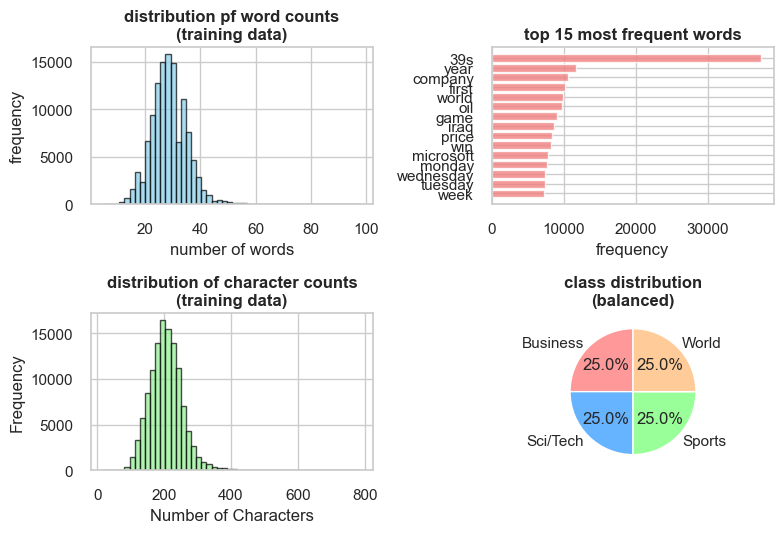

In [20]:
plt.Figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
word_counts = train_df['Processed_Text'].apply(lambda x: len(x.split()))
plt.hist(word_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('distribution pf word counts\n(training data)', fontweight='bold')
plt.xlabel('number of words')
plt.ylabel('frequency')

plt.subplot(2, 2, 2)
words, counts = zip(*most_common_words[:15])
plt.barh(range(len(words)), counts, color='lightcoral', alpha=0.8)
plt.yticks(range(len(words)), words)
plt.title('top 15 most frequent words', fontweight='bold')
plt.xlabel('frequency')
plt.gca().invert_yaxis()

plt.subplot(2, 2, 3)
char_counts = train_df['Processed_Text'].apply(len)
plt.hist(char_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('distribution of character counts\n(training data)', fontweight='bold')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
class_counts = train_df['Class_Name'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('class distribution\n(balanced)', fontweight='bold')

plt.tight_layout()
plt.show()

In [21]:
final_train_columns = ['Class Index', 'Class_Name', 'Processed_Text']
final_test_columns = ['Class Index', 'Class_Name', 'Processed_Text']

train_final = train_df[final_train_columns].copy()
test_final = test_df[final_test_columns].copy()

print("original vs. processed (first 2 samples):")
for i in range(2):
    print(f"sample {i+1} (class: {train_df.iloc[i]['Class_Name']}) ---")
    print(f"original: {train_df.iloc[i]['Combined_Text'][:100]}...")
    print(f"processed: {train_df.iloc[i]['Processed_Text'][:100]}...")

original vs. processed (first 2 samples):
sample 1 (class: Business) ---
original: Wall St. Bears Claw Back Into the Black (Reuters) Wall St. Bears Claw Back Into the Black (Reuters) ...
processed: wall bear claw back black wall bear claw back black shortsellers wall street dwindlingband ultracyni...
sample 2 (class: Business) ---
original: Carlyle Looks Toward Commercial Aerospace (Reuters) Carlyle Looks Toward Commercial Aerospace (Reute...
processed: carlyle look toward commercial aerospace carlyle look toward commercial aerospace private investment...


# Feature Engineering with TF-IDF Vectorization

In [22]:
print(f"training samples: {len(train_df):,}")
print(f"test samples: {len(test_df):,}")
print(f"vocabulary size: {vocabulary_size:,} unique words")

training samples: 120,000
test samples: 7,600
vocabulary size: 93,513 unique words


In [23]:
X_train = train_df['Processed_Text']
y_train = train_df['Class Index'] - 1  
X_test = test_df['Processed_Text'] 
y_test = test_df['Class Index'] - 1

In [24]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,         
    min_df=5,                    
    max_df=0.8,               
    stop_words='english',       
    ngram_range=(1, 2),         
    sublinear_tf=True,          
    smooth_idf=True,            
    lowercase=True              
)

print(f"\nfitting TF-IDF on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f"training matrix shape: {X_train_tfidf.shape}")
print(f"sparsity: {(1 - X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100:.1f}%")

print(f"\ntransforming test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"test matrix shape: {X_test_tfidf.shape}")

feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"vocabulary size: {len(feature_names):,} features")


fitting TF-IDF on training data...
training matrix shape: (120000, 10000)
sparsity: 99.8%

transforming test data...
test matrix shape: (7600, 10000)
vocabulary size: 10,000 features


In [25]:
def get_top_features_by_class(X_tfidf, y, feature_names, class_mapping, top_n=15):
    if hasattr(y, 'values'):
        y = y.values
    
    top_features_by_class = {}
    
    for class_id in range(len(class_mapping)):
        class_name = class_mapping[class_id + 1]  
        
        class_mask = (y == class_id)
        class_tfidf = X_tfidf[class_mask]
        
        mean_scores = np.array(class_tfidf.mean(axis=0)).flatten()
        
        top_indices = mean_scores.argsort()[-top_n:][::-1]
        top_features = [(feature_names[i], mean_scores[i]) for i in top_indices]
        
        top_features_by_class[class_name] = top_features
        
        print(f"\ntop {top_n} features for {class_name}:")
        for i, (feature, score) in enumerate(top_features, 1):
            print(f"   {i:2d}. {feature:25s} (score: {score:.4f})")
    
    return top_features_by_class

top_features = get_top_features_by_class(X_train_tfidf, y_train, feature_names, class_mapping)


top 15 features for World:
    1. iraq                      (score: 0.0235)
    2. president                 (score: 0.0155)
    3. 39s                       (score: 0.0151)
    4. killed                    (score: 0.0140)
    5. minister                  (score: 0.0138)
    6. iraqi                     (score: 0.0127)
    7. leader                    (score: 0.0127)
    8. election                  (score: 0.0126)
    9. official                  (score: 0.0117)
   10. bush                      (score: 0.0115)
   11. palestinian               (score: 0.0115)
   12. attack                    (score: 0.0112)
   13. people                    (score: 0.0107)
   14. government                (score: 0.0102)
   15. baghdad                   (score: 0.0099)

top 15 features for Sports:
    1. 39s                       (score: 0.0237)
    2. game                      (score: 0.0210)
    3. win                       (score: 0.0203)
    4. team                      (score: 0.0172)
    5. seaso

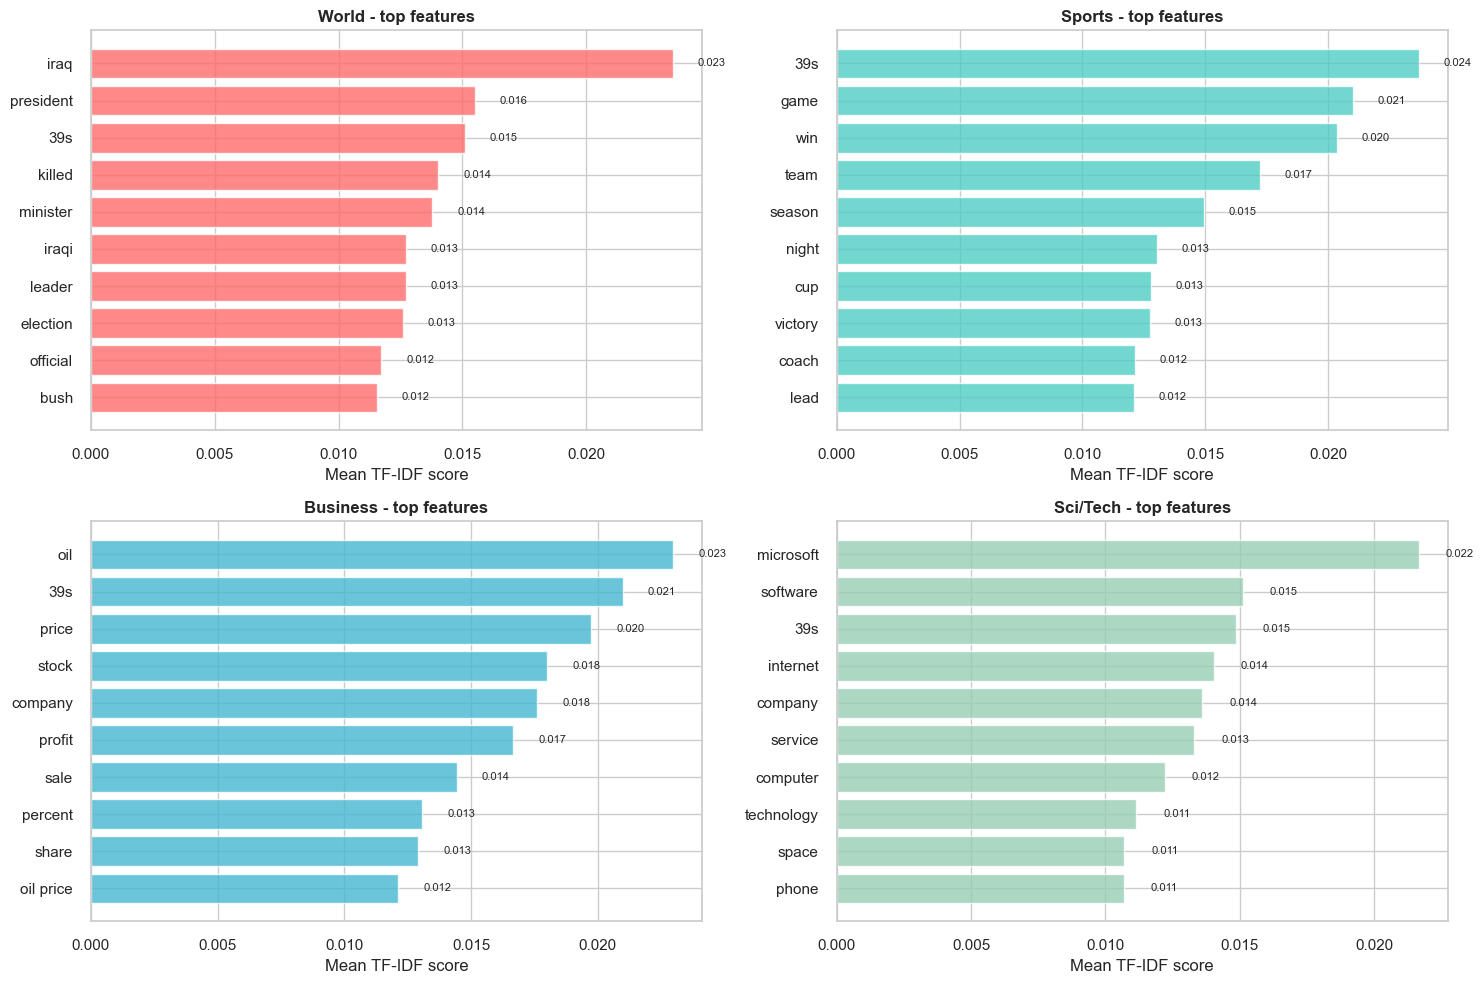

In [26]:
plt.figure(figsize=(15, 10))

for i, (class_name, features) in enumerate(top_features.items()):
    plt.subplot(2, 2, i+1)

    words, scores = zip(*features[:10])
    y_pos = np.arange(len(words))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][i]
    plt.barh(y_pos, scores, color=colors, alpha=0.8)
    plt.yticks(y_pos, words)
    plt.xlabel('Mean TF-IDF score')
    plt.title(f'{class_name} - top features', fontweight='bold', fontsize=12)
    plt.gca().invert_yaxis()

    for j, score in enumerate(scores):
        plt.text(score + 0.001, j, f'{score:.3f}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [27]:
def analyze_tfidf_matrix(X_tfidf, name=""):
    n_samples, n_features = X_tfidf.shape
    nnz = X_tfidf.nnz
    sparsity = (1 - nnz / (n_samples * n_features)) * 100

    sample_size = min(1000, n_samples)
    np.random.seed(42)
    sample_indices = np.random.choice(n_samples, sample_size, replace=False)
    sample_dense = X_tfidf[sample_indices].toarray()

    print(f"shape: {n_samples:,} samples * {n_features:,} features")
    print(f"non zero elements: {nnz:,}")
    print(f"sparsity:{sparsity:.1f}% (mostlly zeros)")
    print(f"memory usage: {X_tfidf.data.nbytes / 1024 / 1024:.1f} MB")
    print(f"mean TF-IDF score: {sample_dense.mean():.6f}")
    print(f"max TF-IDF score: {sample_dense.max():.6f}")
    print(f"features per sample (avg): {nnz / n_samples:.1f}")

analyze_tfidf_matrix(X_train_tfidf, "training")
analyze_tfidf_matrix(X_test_tfidf, "test")

shape: 120,000 samples * 10,000 features
non zero elements: 2,282,477
sparsity:99.8% (mostlly zeros)
memory usage: 17.4 MB
mean TF-IDF score: 0.000401
max TF-IDF score: 0.675464
features per sample (avg): 19.0
shape: 7,600 samples * 10,000 features
non zero elements: 143,364
sparsity:99.8% (mostlly zeros)
memory usage: 1.1 MB
mean TF-IDF score: 0.000398
max TF-IDF score: 0.703616
features per sample (avg): 18.9


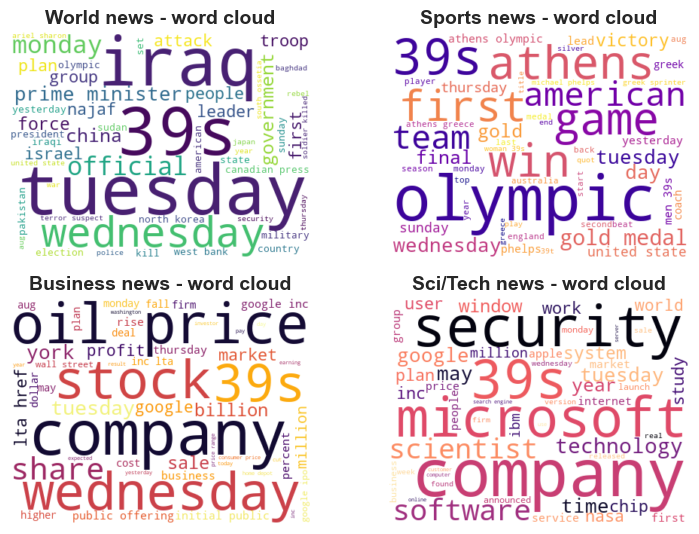

In [28]:
def create_wordclouds(texts_by_class, class_names):
    plt.Figure(figsize=(16, 12))
    
    for i, (class_name, texts) in enumerate(texts_by_class.items()):
        combined_text = ' '.join(texts)
        wordcloud = WordCloud(
            width=400, height=300,
            background_color='white',
            colormap=['viridis', 'plasma', 'inferno', 'magma'][i],
            max_words=50,
            relative_scaling=0.5,
            random_state=42
        ).generate(combined_text)

        plt.subplot(2, 2, i+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{class_name} news - word cloud', fontweight='bold', fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

texts_by_class = {}
for class_id in range(4):
    class_name = class_mapping[class_id + 1]
    mask = (y_train == class_id)
    class_texts = X_train[mask].head(1000).tolist()
    texts_by_class[class_name] = class_texts

create_wordclouds(texts_by_class, class_mapping)

In [29]:
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 1)
)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)
print(f" count features shape: {X_train_counts.shape}")

 count features shape: (120000, 5000)


In [30]:
char_tfidf = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    max_features=5000,
    min_df=5
)

X_train_char = char_tfidf.fit_transform(X_train)
X_test_char = char_tfidf.transform(X_test)
print(f"character TF-IDF shape: {X_train_char.shape}")

character TF-IDF shape: (120000, 5000)


In [31]:
high_dim_tfidf = TfidfVectorizer(
    max_features=50000,
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 3),
    stop_words='english'
)

X_train_high = high_dim_tfidf.fit_transform(X_train)
X_test_high = high_dim_tfidf.transform(X_test)
print(f"high-dim TF-IDF shape: {X_train_high.shape}")

high-dim TF-IDF shape: (120000, 50000)


In [32]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"training set: {X_train_split.shape[0]:,} samples")
print(f"validation set: {X_val_split.shape[0]:,} samples")
print(f"test set: {X_test_tfidf.shape[0]:,} samples")

training set: 96,000 samples
validation set: 24,000 samples
test set: 7,600 samples


In [33]:
print("training split:")
for i in range(4):
    count = (y_train_split == i).sum()
    print(f"{class_mapping[i+1]}: {count:,} samples")

print("validation split:")
for i in range(4):
    count = (y_val_split == i).sum()
    print(f"{class_mapping[i+1]}: {count:,} samples")

training split:
World: 24,000 samples
Sports: 24,000 samples
Business: 24,000 samples
Sci/Tech: 24,000 samples
validation split:
World: 6,000 samples
Sports: 6,000 samples
Business: 6,000 samples
Sci/Tech: 6,000 samples


# Model Training and Evaluation

In [34]:
print(f"Training set: {X_train_split.shape[0]:,} samples, {X_train_split.shape[1]:,} features")
print(f"Validation set: {X_val_split.shape[0]:,} samples")
print(f"Test set: {X_test_tfidf.shape[0]:,} samples")
print(f"Feature sparsity: {(1 - X_train_split.nnz / np.prod(X_train_split.shape)) * 100:.1f}%")

Training set: 96,000 samples, 10,000 features
Validation set: 24,000 samples
Test set: 7,600 samples
Feature sparsity: 99.8%


In [35]:
model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='liblinear',
        multi_class='ovr',
        C=1.0
    )

In [36]:
start_time = time.time()
print(f"training started at {datetime.now().strftime('%H:%M:%S')}")

model.fit(X_train_split, y_train_split)
training_time = time.time() - start_time
print(f"training completed in {training_time:.2f} seconds")

training started at 17:44:47
training completed in 3.37 seconds


In [37]:
val_predictions = model.predict(X_val_split)
val_probabilities = model.predict_proba(X_val_split)

test_predictions = model.predict(X_test_tfidf)
test_probabilities = model.predict_proba(X_test_tfidf)

val_accuracy = accuracy_score(y_val_split, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

validation accuracy: 0.9134 (91.34%)
test accuracy: 0.9086 (90.86%)


In [38]:
print("Generate classification reports:")
val_report = classification_report(
    y_val_split,
    val_predictions,
    target_names=list(class_mapping.values()),
    output_dict=True
)

test_report = classification_report(
    y_test,
    test_predictions,
    target_names=list(class_mapping.values()),
    output_dict=True
)

print("validation set results:")
print(classification_report(
    y_val_split,
    val_predictions,
    target_names=list(class_mapping.values())
))

print("test set results:")
print(classification_report(
    y_test,
    test_predictions,
    target_names=list(class_mapping.values())
))

print("confusion matrix:")
cm = confusion_matrix(y_test, test_predictions)
print("actual\\predicted:", end="")
for class_name in class_mapping.values():
    print(f"{class_name[:8]:>10s}", end="")
print(f"{'total':>8s}")
for i, true_class in enumerate(class_mapping.values()):
    print(f"{true_class[:12]:12s}", end="")
    row_total = 0
    for j in range(len(class_mapping)):
        print(f"{cm[i, j]:10d}", end="")
        row_total += cm[i, j]
    print(f"{row_total:8d}")


print("per-class metrics:")
print(f"{'class':<12} {'precision':<10} {'recall':<10} {'f1-score':<10} {'support':<8}")
for class_name in class_mapping.values():
    if class_name in test_report:
        precision = test_report[class_name]['precision']
        recall = test_report[class_name]['recall']
        f1 = test_report[class_name]['f1-score']
        support = int(test_report[class_name]['support'])
        print(f"{class_name:<12} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<8}")

print("overall metrics:")
macro_avg = test_report['macro avg']
weighted_avg = test_report['weighted avg']
print(f"{'Macro Avg':<12} {macro_avg['precision']:<10.3f} {macro_avg['recall']:<10.3f} {macro_avg['f1-score']:<10.3f}")
print(f"{'Weighted Avg':<12} {weighted_avg['precision']:<10.3f} {weighted_avg['recall']:<10.3f} {weighted_avg['f1-score']:<10.3f}")

Generate classification reports:
validation set results:
              precision    recall  f1-score   support

       World       0.93      0.90      0.91      6000
      Sports       0.95      0.98      0.96      6000
    Business       0.88      0.88      0.88      6000
    Sci/Tech       0.89      0.89      0.89      6000

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000

test set results:
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.94      0.98      0.96      1900
    Business       0.88      0.87      0.87      1900
    Sci/Tech       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

confusion matrix:
actual\predicted:     World    Sports

In [39]:
print("Model confidence analysis:")
max_probs = np.max(test_probabilities, axis=1)
print(f"Average prediction confidence: {np.mean(max_probs):.3f}")
print(f"Median prediction confidence: {np.median(max_probs):.3f}")
print(f"Minimum confidence: {np.min(max_probs):.3f}")
print(f"Maximum confidence: {np.max(max_probs):.3f}")

Model confidence analysis:
Average prediction confidence: 0.838
Median prediction confidence: 0.890
Minimum confidence: 0.271
Maximum confidence: 0.997


In [40]:
print("Confidence distribution:")
low_conf = np.sum(max_probs < 0.5)
med_conf = np.sum((max_probs >= 0.5) & (max_probs < 0.8))
high_conf = np.sum(max_probs >= 0.8)

print(f"Low confidence (<0.5): {low_conf:,} samples ({low_conf/len(max_probs)*100:.1f}%)")
print(f"Medium confidence (0.5-0.8): {med_conf:,} samples ({med_conf/len(max_probs)*100:.1f}%)")
print(f"High confidence (≥0.8): {high_conf:,} samples ({high_conf/len(max_probs)*100:.1f}%)")

Confidence distribution:
Low confidence (<0.5): 319 samples (4.2%)
Medium confidence (0.5-0.8): 1,857 samples (24.4%)
High confidence (≥0.8): 5,424 samples (71.4%)


In [41]:
print("Error analysis:")
misclassified = (y_test != test_predictions)
error_count = np.sum(misclassified)
error_rate = error_count / len(y_test) * 100

print(f"total misclassified samples: {error_count:,} out of {len(y_test):,}")
print(f"error rate: {error_rate:.2f}%")

print(f"most common misclassifications:")
for true_class in range(4):
    for pred_class in range(4):
        if true_class != pred_class:
            count = np.sum((y_test == true_class) & (test_predictions == pred_class))
            if count > 0:
                true_name = class_mapping[true_class + 1]
                pred_name = class_mapping[pred_class + 1]
                percentage = count / np.sum(y_test == true_class) * 100
                print(f"{true_name:>10s} → {pred_name:<10s}: {count:3d} cases ({percentage:4.1f}%)")

results = {
    'model': model,
    'val_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'val_predictions': val_predictions,
    'test_predictions': test_predictions,
    'val_probabilities': val_probabilities,
    'test_probabilities': test_probabilities,
    'val_report': val_report,
    'test_report': test_report,
    'confusion_matrix': cm,
    'training_time': training_time
}

Error analysis:
total misclassified samples: 695 out of 7,600
error rate: 9.14%
most common misclassifications:
     World → Sports    :  62 cases ( 3.3%)
     World → Business  :  97 cases ( 5.1%)
     World → Sci/Tech  :  43 cases ( 2.3%)
    Sports → World     :  13 cases ( 0.7%)
    Sports → Business  :  12 cases ( 0.6%)
    Sports → Sci/Tech  :  14 cases ( 0.7%)
  Business → World     :  58 cases ( 3.1%)
  Business → Sports    :  18 cases ( 0.9%)
  Business → Sci/Tech  : 162 cases ( 8.5%)
  Sci/Tech → World     :  55 cases ( 2.9%)
  Sci/Tech → Sports    :  33 cases ( 1.7%)
  Sci/Tech → Business  : 128 cases ( 6.7%)


In [42]:
print("FINAL SUMMARY")
print(f"Model: Logistic Regression (One-vs-Rest)")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Macro F1-Score: {test_report['macro avg']['f1-score']:.4f}")
print(f"Model Confidence: {np.mean(max_probs):.3f} average")
print(f"Total Features Used: {X_train_split.shape[1]:,}")
print(f"Memory Efficient: {X_train_split.nnz:,} non-zero elements")

if test_accuracy > 0.85:
    print(f"\nModel Performance: EXCELLENT (>85%)")
elif test_accuracy > 0.80:
    print(f"\nModel Performance: GOOD (>80%)")
elif test_accuracy > 0.75:
    print(f"\nModel Performance: ACCEPTABLE (>75%)")
else:
    print(f"\nModel Performance: NEEDS IMPROVEMENT (<75%)")

FINAL SUMMARY
Model: Logistic Regression (One-vs-Rest)
Training Time: 3.37 seconds
Final Test Accuracy: 0.9086 (90.86%)
Macro F1-Score: 0.9083
Model Confidence: 0.838 average
Total Features Used: 10,000
Memory Efficient: 1,826,346 non-zero elements

Model Performance: EXCELLENT (>85%)


# Model Visualization and Analysis

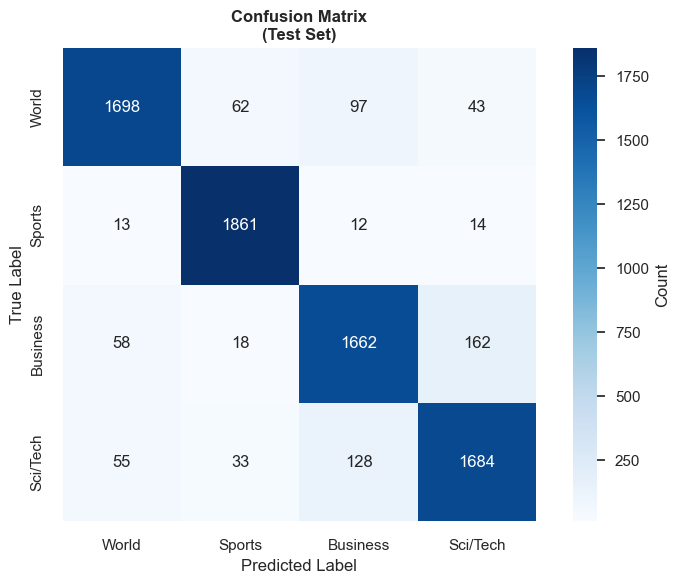

In [43]:
plt.figure(figsize=(8, 6))

class_names = list(class_mapping.values())
sns.heatmap(cm, 
           annot=True, 
           fmt='d', 
           cmap='Blues',
           xticklabels=class_names,
           yticklabels=class_names,
           square=True,
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix\n(Test Set)', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

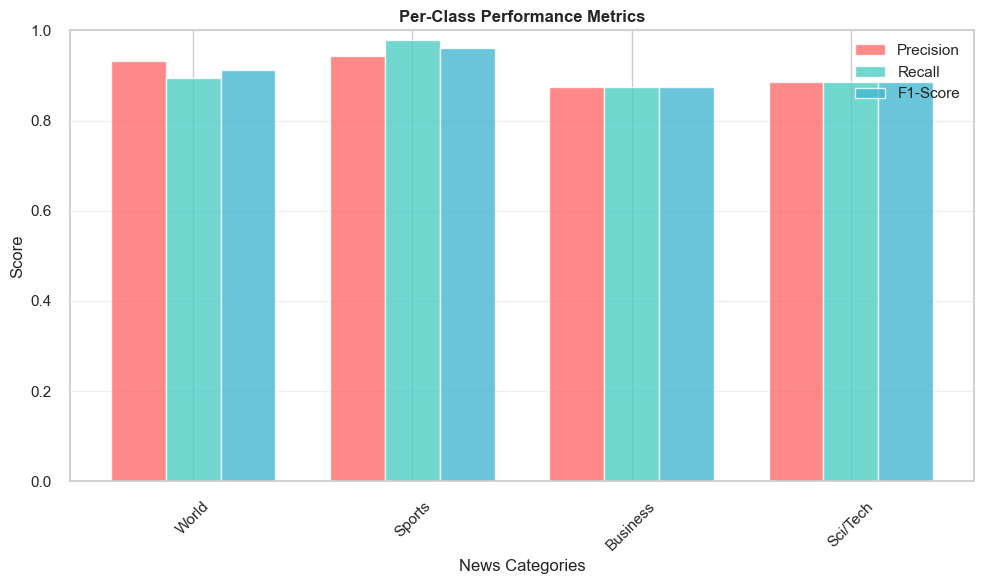

In [44]:
plt.figure(figsize=(10, 6))
metrics_data = []
for class_name in class_names:
    if class_name in test_report:
        metrics_data.append([
            test_report[class_name]['precision'],
            test_report[class_name]['recall'],
            test_report[class_name]['f1-score']
        ])
metrics_array = np.array(metrics_data)
x_pos = np.arange(len(class_names))
width = 0.25
plt.bar(x_pos - width, metrics_array[:, 0], width, label='Precision', alpha=0.8, color='#FF6B6B')
plt.bar(x_pos, metrics_array[:, 1], width, label='Recall', alpha=0.8, color='#4ECDC4')
plt.bar(x_pos + width, metrics_array[:, 2], width, label='F1-Score', alpha=0.8, color='#45B7D1')
plt.xlabel('News Categories')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics', fontweight='bold', fontsize=12)
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

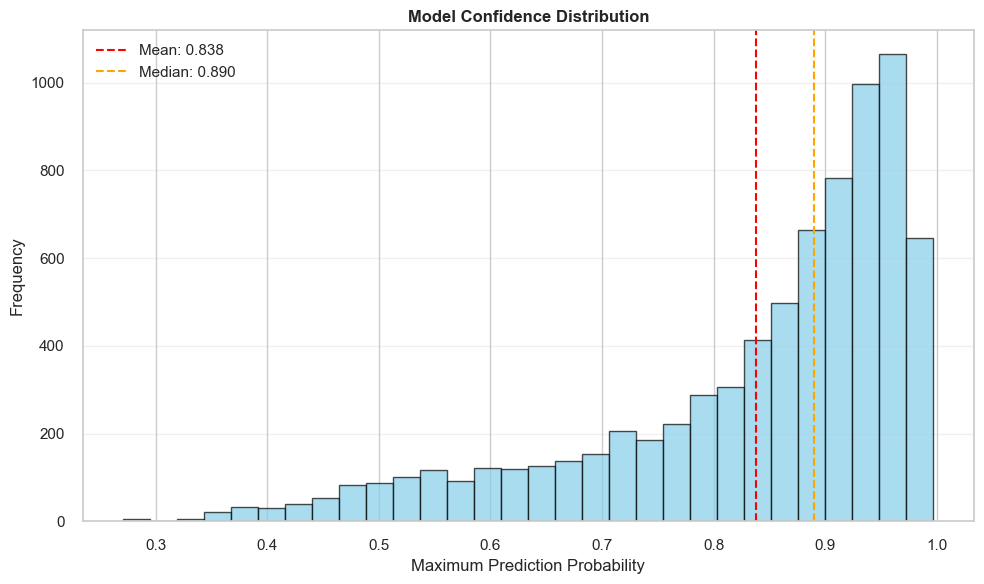

In [45]:
plt.figure(figsize=(10, 6))
max_probs = np.max(test_probabilities, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(max_probs), color='red', linestyle='--', 
           label=f'Mean: {np.mean(max_probs):.3f}')
plt.axvline(np.median(max_probs), color='orange', linestyle='--', 
           label=f'Median: {np.median(max_probs):.3f}')
plt.xlabel('Maximum Prediction Probability')
plt.ylabel('Frequency')
plt.title('Model Confidence Distribution', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

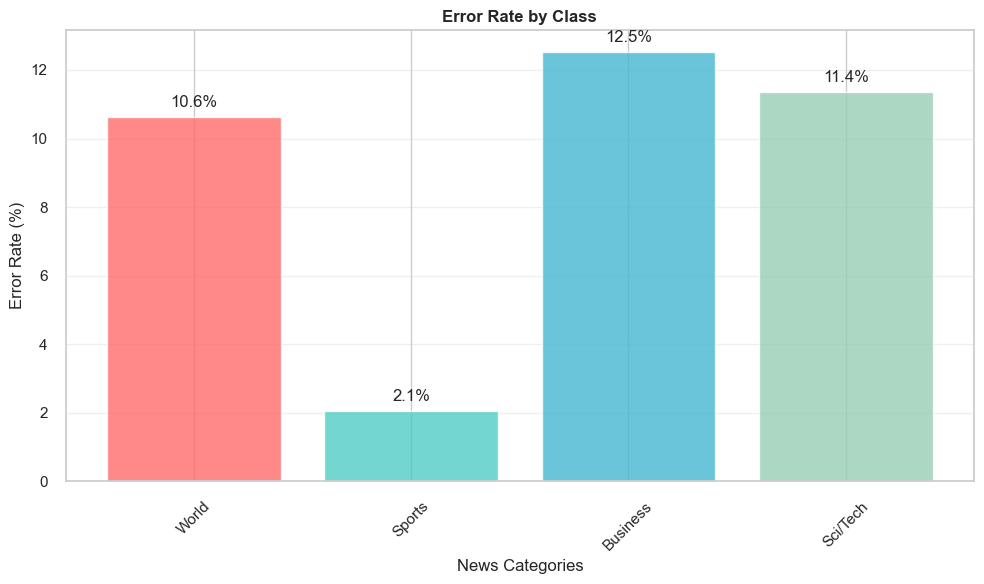

In [46]:
plt.figure(figsize=(10, 6))
error_rates = []
for i in range(4):
    class_total = np.sum(y_test == i)
    class_errors = np.sum((y_test == i) & (test_predictions != i))
    error_rate = class_errors / class_total * 100
    error_rates.append(error_rate)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(class_names, error_rates, color=colors, alpha=0.8)
plt.xlabel('News Categories')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate by Class', fontweight='bold', fontsize=12)
plt.xticks(rotation=45)
for bar, rate in zip(bars, error_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{rate:.1f}%', ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

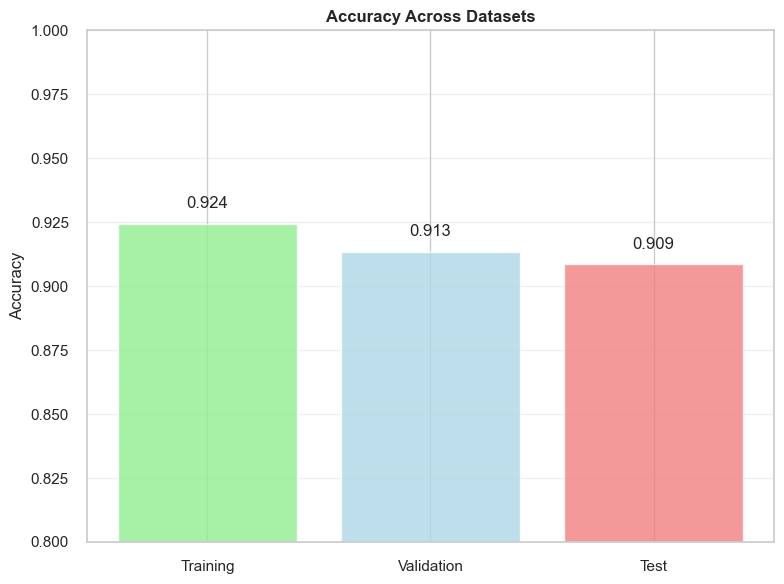

In [47]:
plt.figure(figsize=(8, 6))
train_pred_split = model.predict(X_train_split)
train_accuracy = accuracy_score(y_train_split, train_pred_split)
accuracies = [train_accuracy, val_accuracy, test_accuracy]
labels = ['Training', 'Validation', 'Test']
colors = ['lightgreen', 'lightblue', 'lightcoral']
bars = plt.bar(labels, accuracies, color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Accuracy Across Datasets', fontweight='bold', fontsize=12)
plt.ylim(0.8, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

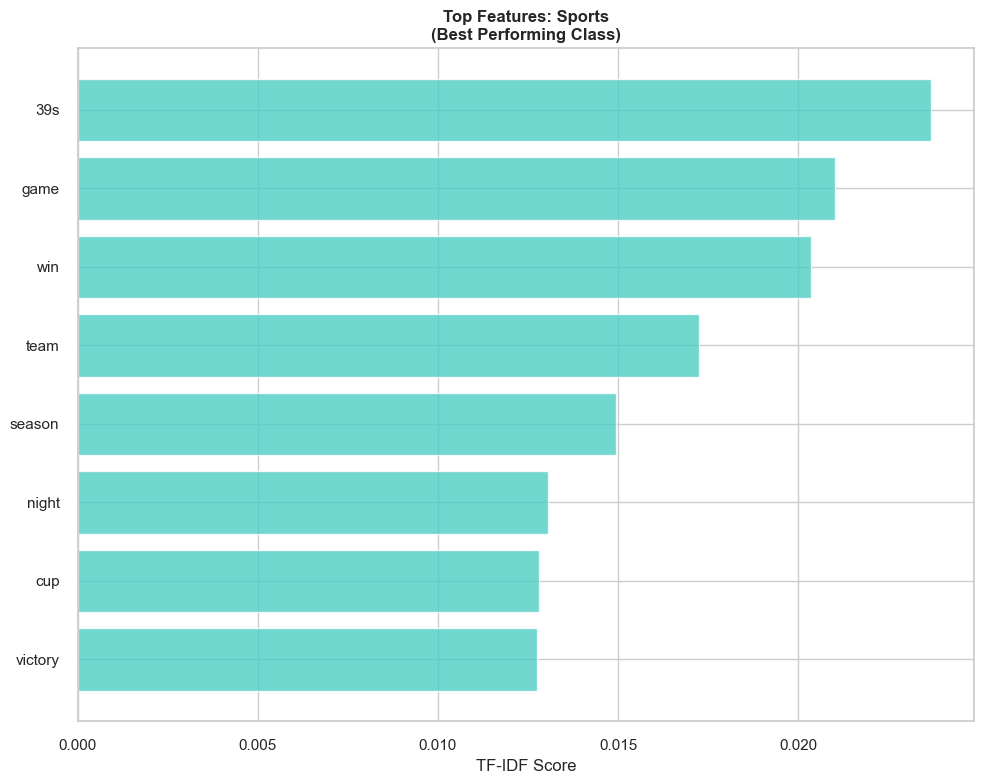

In [48]:
plt.figure(figsize=(10, 8))
sports_features = top_features['Sports'][:8]
words, scores = zip(*sports_features)
plt.barh(range(len(words)), scores, color='#4ECDC4', alpha=0.8)
plt.yticks(range(len(words)), words)
plt.xlabel('TF-IDF Score')
plt.title('Top Features: Sports\n(Best Performing Class)', fontweight='bold', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

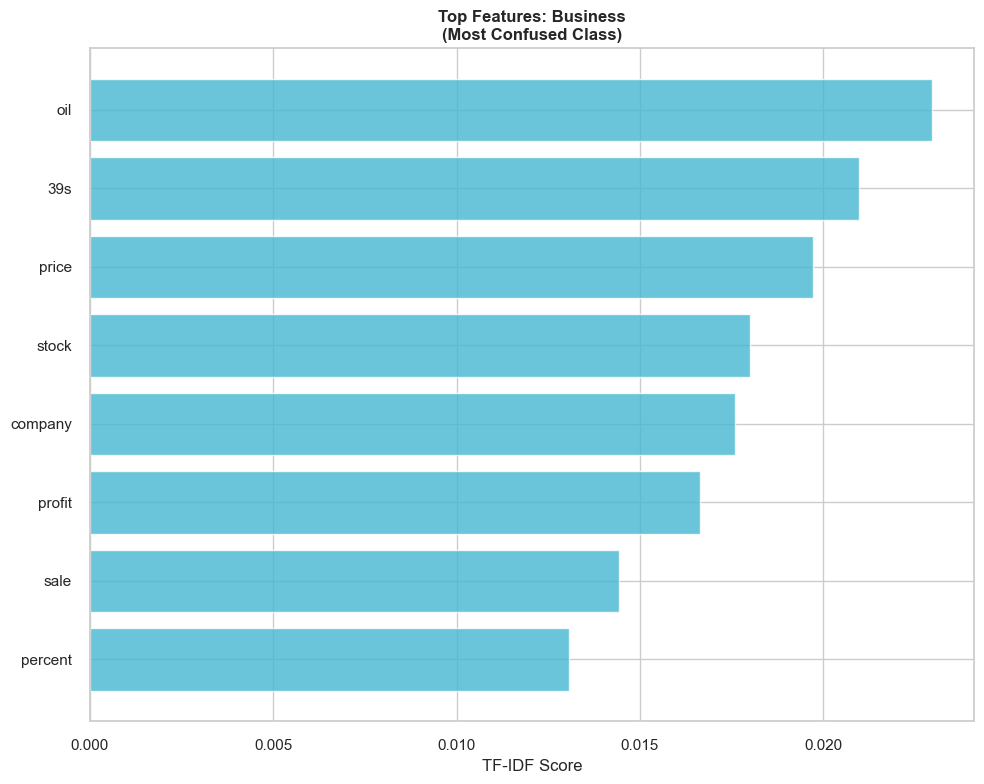

In [49]:
plt.figure(figsize=(10, 8))
business_features = top_features['Business'][:8]
words, scores = zip(*business_features)
plt.barh(range(len(words)), scores, color='#45B7D1', alpha=0.8)
plt.yticks(range(len(words)), words)
plt.xlabel('TF-IDF Score')
plt.title('Top Features: Business\n(Most Confused Class)', fontweight='bold', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

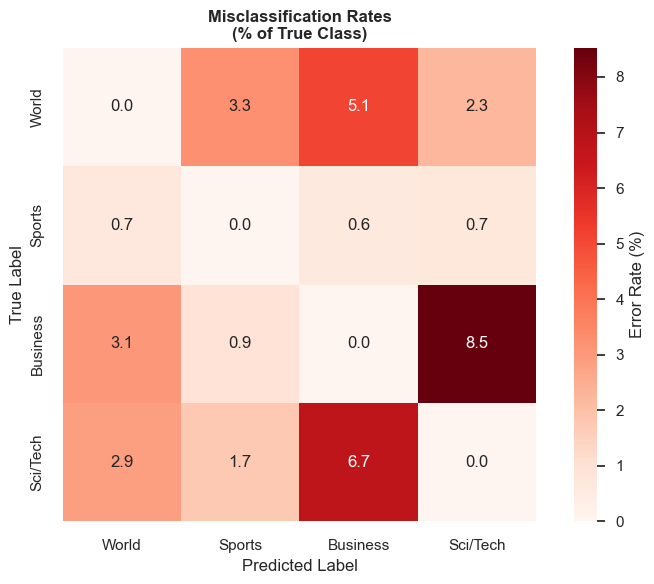

In [50]:
plt.figure(figsize=(8, 6))
misclass_matrix = cm.astype('float')
for i in range(len(class_names)):
    misclass_matrix[i, :] = misclass_matrix[i, :] / cm[i, :].sum() * 100
    misclass_matrix[i, i] = 0  
sns.heatmap(misclass_matrix, 
           annot=True, 
           fmt='.1f', 
           cmap='Reds',
           xticklabels=class_names,
           yticklabels=class_names,
           square=True,
           cbar_kws={'label': 'Error Rate (%)'})
plt.title('Misclassification Rates\n(% of True Class)', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

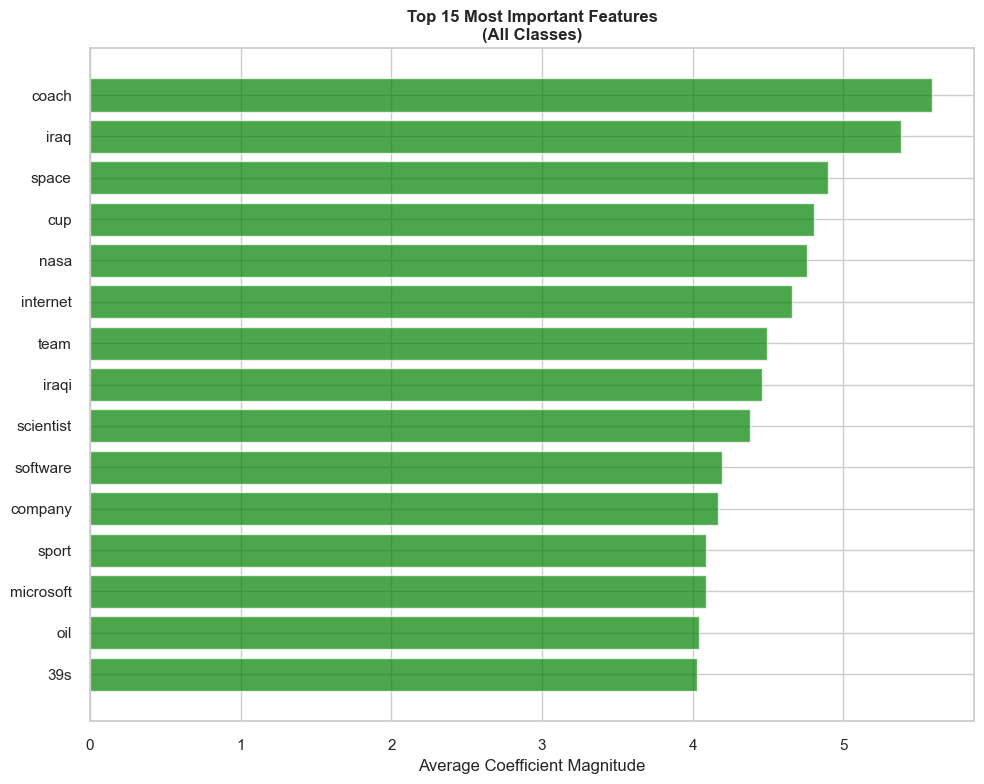

In [51]:
plt.figure(figsize=(10, 8))
feature_importance = np.abs(model.coef_).mean(axis=0)
top_indices = feature_importance.argsort()[-15:][::-1]
top_features_names = [feature_names[i] for i in top_indices]
top_importance_scores = feature_importance[top_indices]
plt.barh(range(len(top_features_names)), top_importance_scores, 
         color='green', alpha=0.7)
plt.yticks(range(len(top_features_names)), top_features_names)
plt.xlabel('Average Coefficient Magnitude')
plt.title('Top 15 Most Important Features\n(All Classes)', fontweight='bold', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

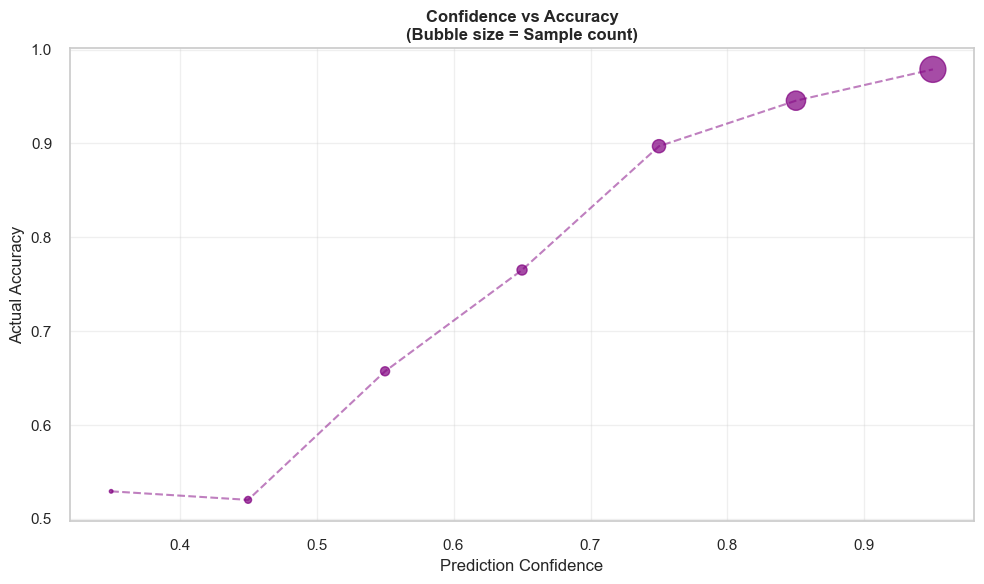

In [52]:
plt.figure(figsize=(10, 6))
confidence_bins = np.arange(0.3, 1.0, 0.1)
bin_accuracies = []
bin_counts = []
for i in range(len(confidence_bins)-1):
    mask = (max_probs >= confidence_bins[i]) & (max_probs < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_accuracy = accuracy_score(y_test[mask], test_predictions[mask])
        bin_accuracies.append(bin_accuracy)
        bin_counts.append(np.sum(mask))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)
mask = max_probs >= confidence_bins[-1]
if np.sum(mask) > 0:
    bin_accuracies.append(accuracy_score(y_test[mask], test_predictions[mask]))
    bin_counts.append(np.sum(mask))
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_centers = np.append(bin_centers, (confidence_bins[-1] + 1.0) / 2)
sizes = [count/10 for count in bin_counts] 
plt.scatter(bin_centers[:len(bin_accuracies)], bin_accuracies, s=sizes, alpha=0.7, c='purple')
plt.plot(bin_centers[:len(bin_accuracies)], bin_accuracies, 'purple', alpha=0.5, linestyle='--')
plt.xlabel('Prediction Confidence')
plt.ylabel('Actual Accuracy')
plt.title('Confidence vs Accuracy\n(Bubble size = Sample count)', fontweight='bold', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

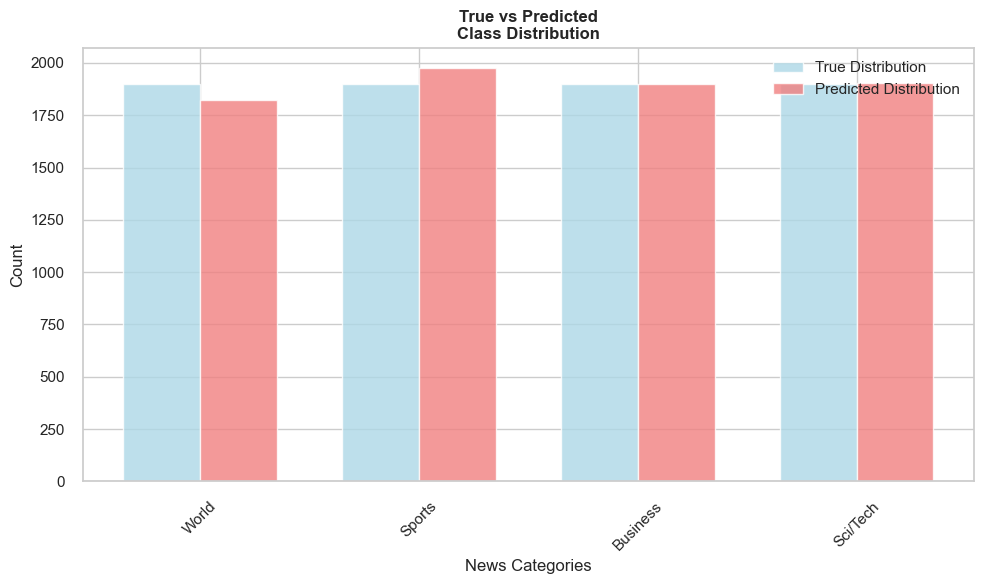

In [53]:
plt.figure(figsize=(10, 6))
true_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(test_predictions).value_counts().sort_index()
x_pos = np.arange(len(class_names))
width = 0.35
plt.bar(x_pos - width/2, true_counts.values, width, 
        label='True Distribution', alpha=0.8, color='lightblue')
plt.bar(x_pos + width/2, pred_counts.values, width, 
        label='Predicted Distribution', alpha=0.8, color='lightcoral')
plt.xlabel('News Categories')
plt.ylabel('Count')
plt.title('True vs Predicted\nClass Distribution', fontweight='bold', fontsize=12)
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
print("Detailed Error Cases:")
wrong_mask = (y_test != test_predictions)
wrong_confidences = max_probs[wrong_mask]
wrong_indices = np.where(wrong_mask)[0]

confident_errors_idx = wrong_indices[np.argsort(wrong_confidences)[::-1]]

print("top 5 most confident wrong predictions:")
for i, idx in enumerate(confident_errors_idx[:5]):
    true_class = class_mapping[y_test[idx] + 1]
    pred_class = class_mapping[test_predictions[idx] + 1]
    confidence = max_probs[idx]
    
    original_text = test_df.iloc[idx]['Combined_Text'][:100]
    
    print(f"{i+1}. true: {true_class}, predicted: {pred_class}")
    print(f"confidence: {confidence:.3f}")
    print(f"text: {original_text}...")

Detailed Error Cases:
top 5 most confident wrong predictions:
1. true: Business, predicted: Sci/Tech
confidence: 0.979
text: Microsoft Readies Next Business IM Server Microsoft Readies Next Business IM Server A little over a ...
2. true: Business, predicted: Sci/Tech
confidence: 0.978
text: Sony, IBM, Toshiba Give Details of 'Cell' Chip (Reuters) Sony, IBM, Toshiba Give Details of 'Cell' C...
3. true: World, predicted: Sports
confidence: 0.974
text: Argentina Basketball Coach Magnano Quits Argentina Basketball Coach Magnano Quits Ruben Magnano, who...
4. true: World, predicted: Sports
confidence: 0.967
text: Munro, Morris Face Off in NLCS Game 2 Munro, Morris Face Off in NLCS Game 2 ST. LOUIS - The Houston ...
5. true: Business, predicted: Sci/Tech
confidence: 0.966
text: Linux: Paris weighs a shift to open-source camp Linux: Paris weighs a shift to open-source camp PARI...


# Additional Classifiers Training

In [55]:
all_model_results = {}
all_model_results['Logistic Regression'] = {
    'model': model,
    'test_accuracy': test_accuracy,
    'test_predictions': test_predictions,
    'test_probabilities': test_probabilities,
    'training_time': training_time
}

print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f} (already trained)")

Logistic Regression Test Accuracy: 0.9086 (already trained)


In [56]:
print("\n1. Training Random Forest...")
rf_start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_split, y_train_split)
rf_training_time = time.time() - rf_start_time

rf_val_predictions = rf_model.predict(X_val_split)
rf_test_predictions = rf_model.predict(X_test_tfidf)
rf_test_probabilities = rf_model.predict_proba(X_test_tfidf)

rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

print(f"Random Forest training completed in {rf_training_time:.2f} seconds")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f} ({rf_test_accuracy*100:.2f}%)")

all_model_results['Random Forest'] = {
    'model': rf_model,
    'test_accuracy': rf_test_accuracy,
    'test_predictions': rf_test_predictions,
    'test_probabilities': rf_test_probabilities,
    'training_time': rf_training_time
}


1. Training Random Forest...
Random Forest training completed in 2.49 seconds
Random Forest Test Accuracy: 0.8037 (80.37%)


In [57]:
print("\n2. Training Multinomial Naive Bayes...")
nb_start_time = time.time()

nb_model = MultinomialNB(
    alpha=0.1 
)

nb_model.fit(X_train_split, y_train_split)
nb_training_time = time.time() - nb_start_time

nb_val_predictions = nb_model.predict(X_val_split)
nb_test_predictions = nb_model.predict(X_test_tfidf)
nb_test_probabilities = nb_model.predict_proba(X_test_tfidf)

nb_test_accuracy = accuracy_score(y_test, nb_test_predictions)

print(f"Multinomial Naive Bayes training completed in {nb_training_time:.2f} seconds")
print(f"Multinomial Naive Bayes Test Accuracy: {nb_test_accuracy:.4f} ({nb_test_accuracy*100:.2f}%)")

all_model_results['Multinomial Naive Bayes'] = {
    'model': nb_model,
    'test_accuracy': nb_test_accuracy,
    'test_predictions': nb_test_predictions,
    'test_probabilities': nb_test_probabilities,
    'training_time': nb_training_time
}


2. Training Multinomial Naive Bayes...
Multinomial Naive Bayes training completed in 0.02 seconds
Multinomial Naive Bayes Test Accuracy: 0.9005 (90.05%)


In [58]:
print("model comparison summary")
print(f"{'Model':<20} {'Test Accuracy':<15} {'Training Time':<15}")

best_model_name = max(all_model_results.keys(), key=lambda x: all_model_results[x]['test_accuracy'])

for model_name, results in all_model_results.items():
    accuracy = results['test_accuracy']
    time_taken = results['training_time']
    marker = " * BEST" if model_name == best_model_name else ""
    
    print(f"{model_name:<20} {accuracy:<15.4f} {time_taken:<15.2f}{marker}")

best_model_results = all_model_results[best_model_name]
best_model = best_model_results['model']
best_predictions = best_model_results['test_predictions']
best_probabilities = best_model_results['test_probabilities']

print(f"BEST PERFORMING MODEL: {best_model_name}")
print(f"Best Test Accuracy: {best_model_results['test_accuracy']:.4f} ({best_model_results['test_accuracy']*100:.2f}%)")

model comparison summary
Model                Test Accuracy   Training Time  
Logistic Regression  0.9086          3.37            * BEST
Random Forest        0.8037          2.49           
Multinomial Naive Bayes 0.9005          0.02           
BEST PERFORMING MODEL: Logistic Regression
Best Test Accuracy: 0.9086 (90.86%)


In [59]:
print(f"Detailed Classification Report - {best_model_name}:")
print(classification_report(y_test, best_predictions, target_names=list(class_mapping.values())))

if best_model_name == 'Random Forest':
    print(f"\nTop 15 Most Important Features ({best_model_name}):")
    feature_importance = best_model.feature_importances_
    top_indices = feature_importance.argsort()[-15:][::-1]
    
    for i, idx in enumerate(top_indices, 1):
        feature_name = feature_names[idx]
        importance = feature_importance[idx]
        print(f"{i:2d}. {feature_name:25s} (importance: {importance:.4f})")

Detailed Classification Report - Logistic Regression:
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.94      0.98      0.96      1900
    Business       0.88      0.87      0.87      1900
    Sci/Tech       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



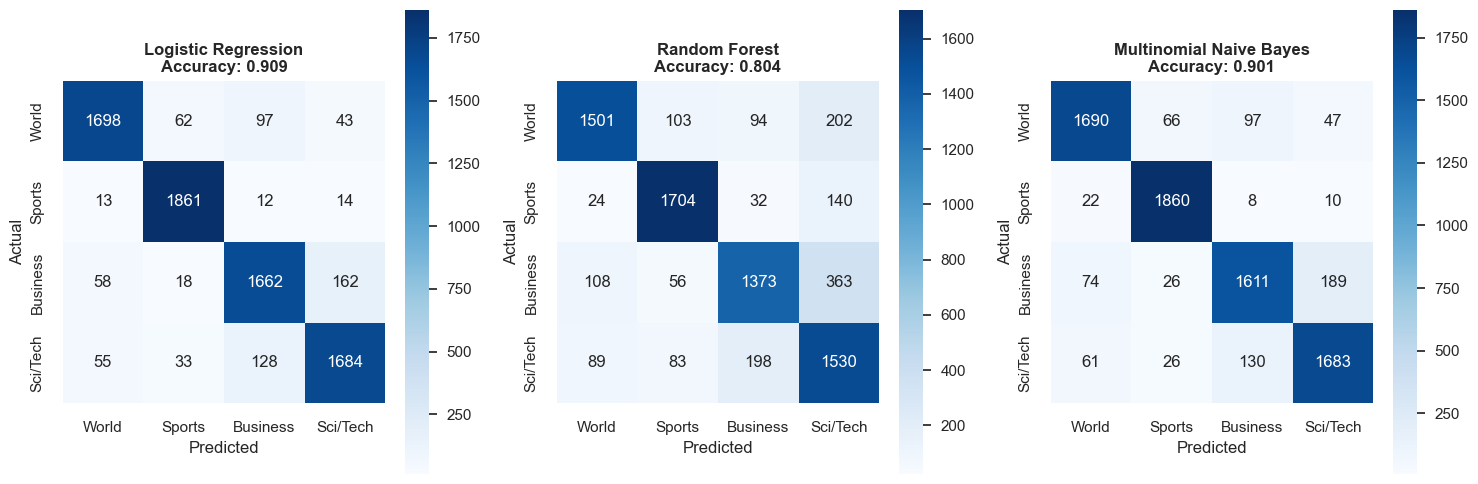

In [60]:
plt.figure(figsize=(15, 5))

for i, (model_name, results) in enumerate(all_model_results.items()):
    plt.subplot(1, 3, i+1)
    
    cm = confusion_matrix(y_test, results['test_predictions'])
    sns.heatmap(cm, 
               annot=True, 
               fmt='d', 
               cmap='Blues',
               xticklabels=list(class_mapping.values()),
               yticklabels=list(class_mapping.values()),
               square=True)
    
    accuracy = results['test_accuracy']
    plt.title(f'{model_name}\nAccuracy: {accuracy:.3f}', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

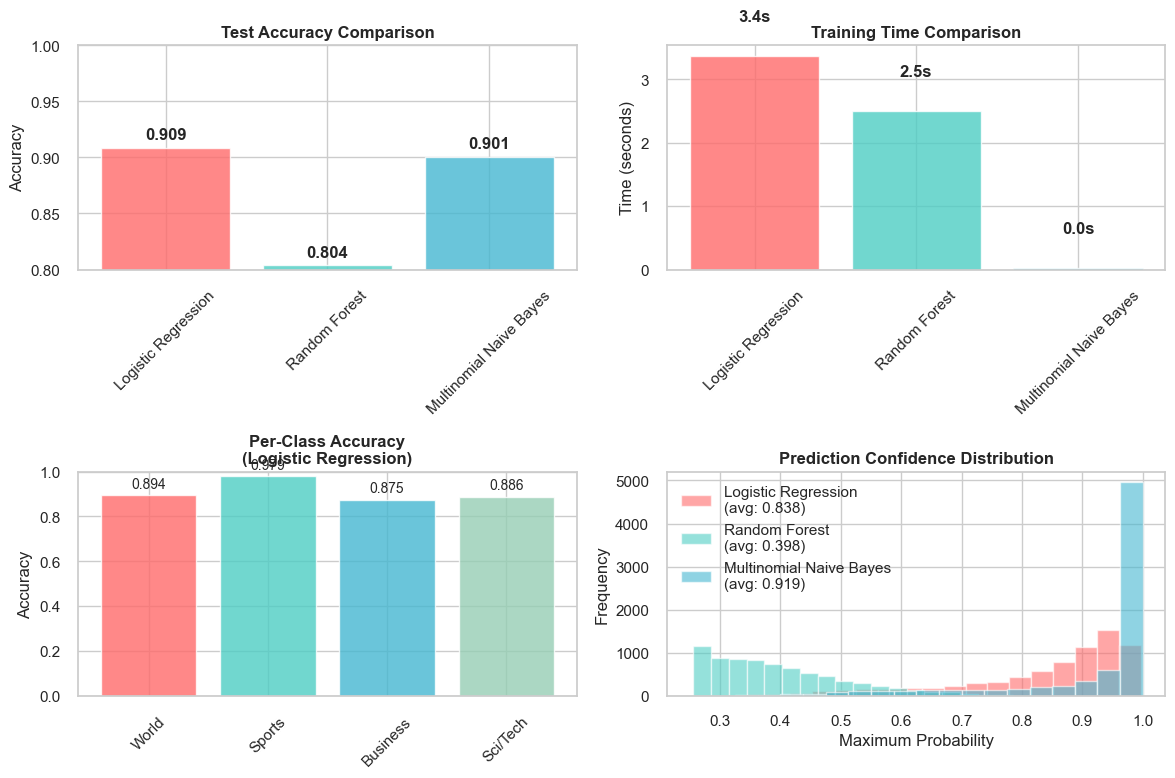

In [61]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
models = list(all_model_results.keys())
accuracies = [all_model_results[model]['test_accuracy'] for model in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Test Accuracy Comparison', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)


plt.subplot(2, 2, 2)
times = [all_model_results[model]['training_time'] for model in models]
bars = plt.bar(models, times, color=colors, alpha=0.8)
plt.title('Training Time Comparison', fontweight='bold')
plt.ylabel('Time (seconds)')
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)


plt.subplot(2, 2, 3)
best_cm = confusion_matrix(y_test, best_predictions)
class_accuracies = []
for i in range(4):
    class_acc = best_cm[i, i] / best_cm[i, :].sum() if best_cm[i, :].sum() > 0 else 0
    class_accuracies.append(class_acc)
class_names = list(class_mapping.values())
bars = plt.bar(class_names, class_accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
plt.title(f'Per-Class Accuracy\n({best_model_name})', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)


plt.subplot(2, 2, 4)
for i, (model_name, results) in enumerate(all_model_results.items()):
    if results['test_probabilities'] is not None:
        max_probs = np.max(results['test_probabilities'], axis=1)
        plt.hist(max_probs, bins=20, alpha=0.6, label=f'{model_name}\n(avg: {np.mean(max_probs):.3f})', color=colors[i])
plt.title('Prediction Confidence Distribution', fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
print(f"Best Model: {best_model_name} with {best_model_results['test_accuracy']*100:.2f}% accuracy")

Best Model: Logistic Regression with 90.86% accuracy


# Bonus: Neural Network Implementation

In [63]:
print("1. Creating smaller TF-IDF for Neural Network...")

tfidf_nn = TfidfVectorizer(
    max_features=5000,  
    min_df=5,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_train_nn_sparse = tfidf_nn.fit_transform(X_train)
X_test_nn_sparse = tfidf_nn.transform(X_test)

X_train_split_nn, X_val_split_nn, y_train_split_nn, y_val_split_nn = train_test_split(
    X_train_nn_sparse, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"Original TF-IDF shape: {X_train_split.shape}")
print(f"Reduced TF-IDF shape: {X_train_split_nn.shape}")
print(f"Memory reduction: {X_train_split.shape[1] / X_train_split_nn.shape[1]:.1f}x smaller")

1. Creating smaller TF-IDF for Neural Network...
Original TF-IDF shape: (96000, 10000)
Reduced TF-IDF shape: (96000, 5000)
Memory reduction: 2.0x smaller


In [64]:
print("\n2. Converting to dense arrays...")
try:
    X_train_nn = X_train_split_nn.toarray()
    X_val_nn = X_val_split_nn.toarray()
    X_test_nn = X_test_nn_sparse.toarray()
    
    print(f"Training data shape: {X_train_nn.shape}")
    print(f"Validation data shape: {X_val_nn.shape}")
    print(f"Test data shape: {X_test_nn.shape}")
    print("Dense conversion successful!")
    
except MemoryError:
    print("Still not enough memory. Using alternative approach...")
    
    tfidf_nn_small = TfidfVectorizer(
        max_features=2000, 
        min_df=10,
        max_df=0.7,
        stop_words='english',
        ngram_range=(1, 1)  
    )
    
    X_train_nn_sparse = tfidf_nn_small.fit_transform(X_train)
    X_test_nn_sparse = tfidf_nn_small.transform(X_test)
    
    X_train_split_nn, X_val_split_nn, y_train_split_nn, y_val_split_nn = train_test_split(
        X_train_nn_sparse, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )
    
    X_train_nn = X_train_split_nn.toarray()
    X_val_nn = X_val_split_nn.toarray()
    X_test_nn = X_test_nn_sparse.toarray()
    
    print(f"Using smaller dimensions: {X_train_nn.shape}")


2. Converting to dense arrays...
Training data shape: (96000, 5000)
Validation data shape: (24000, 5000)
Test data shape: (7600, 5000)
Dense conversion successful!


In [65]:
y_train_nn = to_categorical(y_train_split_nn, num_classes=4)
y_val_nn = to_categorical(y_val_split_nn, num_classes=4)
y_test_nn = to_categorical(y_test, num_classes=4)

print(f"Label shape after one-hot encoding: {y_train_nn.shape}")

Label shape after one-hot encoding: (96000, 4)


In [66]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train_nn)
X_val_nn = scaler.transform(X_val_nn)
X_test_nn = scaler.transform(X_test_nn)

In [67]:
print("building neural network architecture...")
def create_neural_network(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,), name='hidden_1'),
        Dropout(0.3, name='dropout_1'),
        
        Dense(128, activation='relu', name='hidden_2'),
        Dropout(0.3, name='dropout_2'),
        
        Dense(64, activation='relu', name='hidden_3'),
        Dropout(0.2, name='dropout_3'),
        
        Dense(4, activation='softmax', name='output')
    ])
    
    return model

building neural network architecture...


In [68]:
nn_model = create_neural_network(X_train_nn.shape[1])

In [69]:
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Neural Network Architecture:")
nn_model.summary()

Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,668 (5.04 MB)

 Trainable params: 1,321,668 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

In [71]:
print("\n4. Training Neural Network...")
nn_start_time = time.time()

history = nn_model.fit(
    X_train_nn, y_train_nn,
    batch_size=128,
    epochs=20,  
    validation_data=(X_val_nn, y_val_nn),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

nn_training_time = time.time() - nn_start_time
print(f"\nNeural Network training completed in {nn_training_time:.2f} seconds")


4. Training Neural Network...
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.7491 - loss: 0.6576 - val_accuracy: 0.9048 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9162 - loss: 0.2569 - val_accuracy: 0.9073 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9299 - loss: 0.2041 - val_accuracy: 0.9056 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9408 - loss: 0.1664 - val_accuracy: 0.9056 - val_loss: 0.3165 - learning_rate: 0.0010
Epoch 5/20
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9506 - loss: 0.1370
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9505 - loss: 0.1370 - val_accuracy: 0.9028 - val_loss: 0.3290 - learning_rate: 0.0010
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 66m

In [72]:
print("\n5. Evaluating Neural Network...")

nn_val_pred_proba = nn_model.predict(X_val_nn, verbose=0)
nn_test_pred_proba = nn_model.predict(X_test_nn, verbose=0)

nn_val_predictions = np.argmax(nn_val_pred_proba, axis=1)
nn_test_predictions = np.argmax(nn_test_pred_proba, axis=1)

nn_val_accuracy = accuracy_score(y_val_split_nn, nn_val_predictions)
nn_test_accuracy = accuracy_score(y_test, nn_test_predictions)

print(f"Neural Network Validation Accuracy: {nn_val_accuracy:.4f} ({nn_val_accuracy*100:.2f}%)")
print(f"Neural Network Test Accuracy: {nn_test_accuracy:.4f} ({nn_test_accuracy*100:.2f}%)")

all_model_results['Neural Network'] = {
    'model': nn_model,
    'test_accuracy': nn_test_accuracy,
    'test_predictions': nn_test_predictions,
    'test_probabilities': nn_test_pred_proba,
    'training_time': nn_training_time
}


5. Evaluating Neural Network...
Neural Network Validation Accuracy: 0.9073 (90.73%)
Neural Network Test Accuracy: 0.8986 (89.86%)


In [73]:
print("Updated model comparison (inclusing neural network)")
print(f"{'Model':<25} {'Test Accuracy':<15} {'Training Time':<15}")

best_model_name = max(all_model_results.keys(), key=lambda x: all_model_results[x]['test_accuracy'])

for model_name, results in all_model_results.items():
    accuracy = results['test_accuracy']
    time_taken = results['training_time']
    marker = " ★ BEST" if model_name == best_model_name else ""
    
    print(f"{model_name:<25} {accuracy:<15.4f} {time_taken:<15.2f}{marker}")

Updated model comparison (inclusing neural network)
Model                     Test Accuracy   Training Time  
Logistic Regression       0.9086          3.37            ★ BEST
Random Forest             0.8037          2.49           
Multinomial Naive Bayes   0.9005          0.02           
Neural Network            0.8986          164.71         



5. Visualizing Neural Network Training...


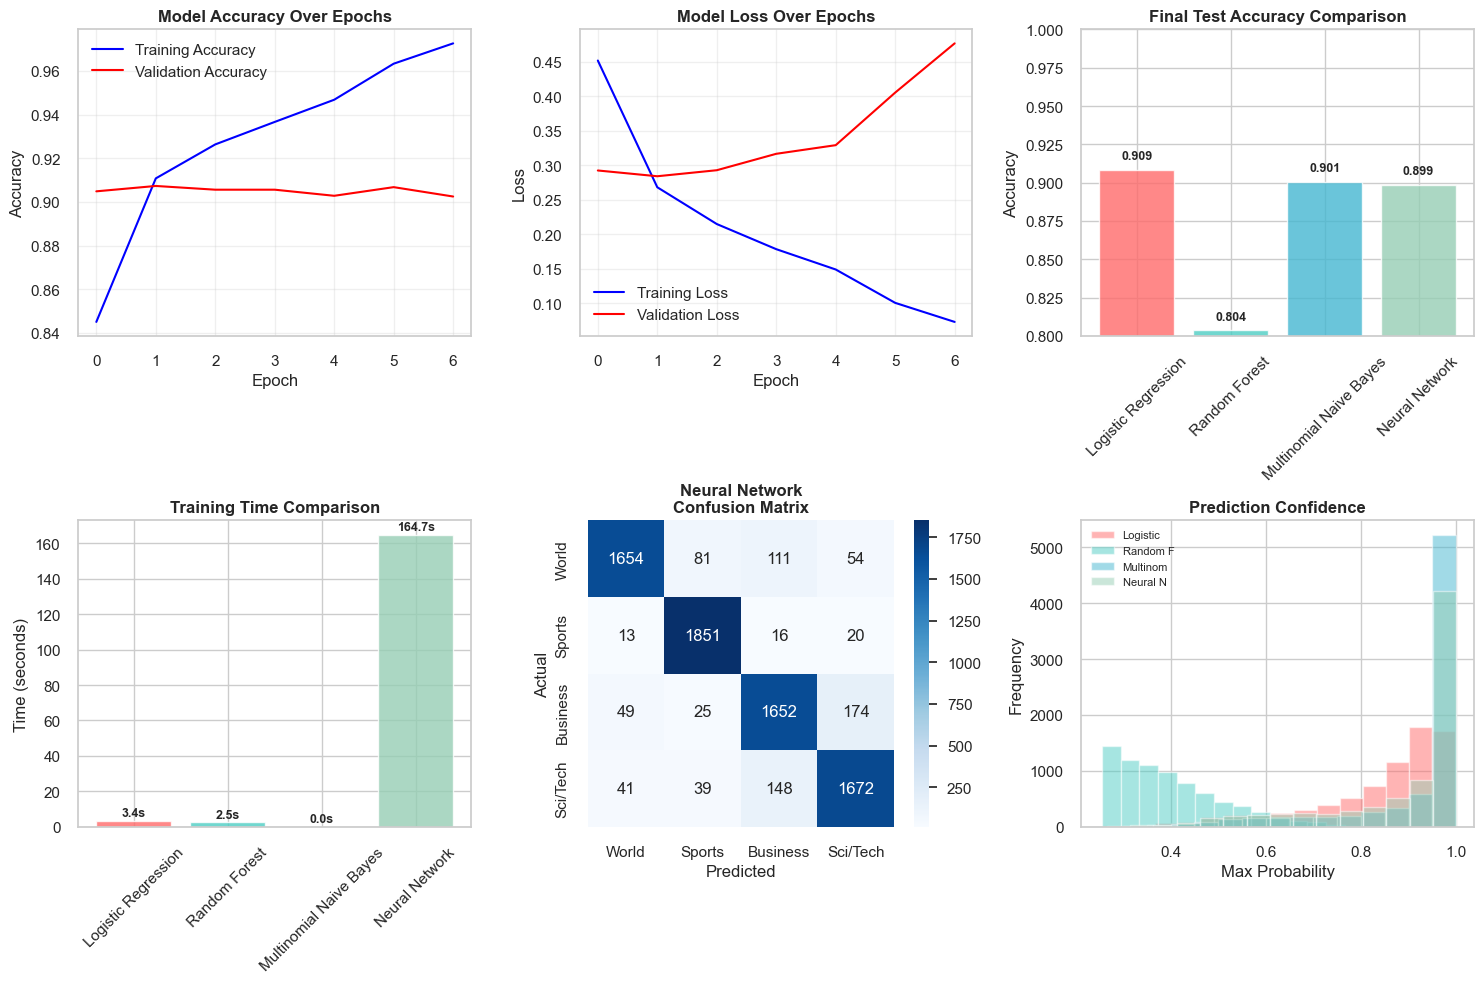

In [74]:
print("\n5. Visualizing Neural Network Training...")

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Epochs', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
models = list(all_model_results.keys())
accuracies = [all_model_results[model]['test_accuracy'] for model in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Final Test Accuracy Comparison', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.subplot(2, 3, 4)
times = [all_model_results[model]['training_time'] for model in models]
bars = plt.bar(models, times, color=colors, alpha=0.8)
plt.title('Training Time Comparison', fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.subplot(2, 3, 5)
nn_cm = confusion_matrix(y_test, nn_test_predictions)
sns.heatmap(nn_cm, 
           annot=True, 
           fmt='d', 
           cmap='Blues',
           xticklabels=list(class_mapping.values()),
           yticklabels=list(class_mapping.values()),
           square=True)
plt.title('Neural Network\nConfusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 6)
for i, (model_name, results) in enumerate(all_model_results.items()):
    if results['test_probabilities'] is not None:
        max_probs = np.max(results['test_probabilities'], axis=1)
        plt.hist(max_probs, bins=15, alpha=0.5, label=f'{model_name[:8]}', color=colors[i])
plt.title('Prediction Confidence', fontweight='bold')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [75]:
print("\n6. Neural Network Classification Report:")
print(classification_report(y_test, nn_test_predictions, target_names=list(class_mapping.values())))


6. Neural Network Classification Report:
              precision    recall  f1-score   support

       World       0.94      0.87      0.90      1900
      Sports       0.93      0.97      0.95      1900
    Business       0.86      0.87      0.86      1900
    Sci/Tech       0.87      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



In [76]:
print("All models trained successfully:")
for model_name, results in all_model_results.items():
    print(f"{model_name}: {results['test_accuracy']:.3f} accuracy")

print(f"\nBEST PERFORMING MODEL: {best_model_name}")
print(f"   Final Accuracy: {all_model_results[best_model_name]['test_accuracy']:.4f} ({all_model_results[best_model_name]['test_accuracy']*100:.2f}%)")

print(f"\nFINAL SUMMARY:")
print(f"Dataset: {len(train_df):,} training + {len(test_df):,} test samples")
print(f"Original TF-IDF features: {X_train_tfidf.shape[1]:,}")
print(f"Neural Network features: {X_train_nn.shape[1]:,}")
print(f"Classes: {len(class_mapping)} news categories")
print(f"Models trained: {len(all_model_results)} different algorithms")

All models trained successfully:
Logistic Regression: 0.909 accuracy
Random Forest: 0.804 accuracy
Multinomial Naive Bayes: 0.901 accuracy
Neural Network: 0.899 accuracy

BEST PERFORMING MODEL: Logistic Regression
   Final Accuracy: 0.9086 (90.86%)

FINAL SUMMARY:
Dataset: 120,000 training + 7,600 test samples
Original TF-IDF features: 10,000
Neural Network features: 5,000
Classes: 4 news categories
Models trained: 4 different algorithms


# Model Saving and Dependencies

In [78]:
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created Directory: {models_dir}")

Created Directory: saved_models


In [80]:
print("1. saving tfidf vectorizer...")
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
with open(vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"tfidf vectorizer saved ro: {vectorizer_path}")

1. saving tfidf vectorizer...
tfidf vectorizer saved ro: saved_models\tfidf_vectorizer.pkl


In [81]:
print("2. saving trained models...")
for model_name, results in all_model_results.items():
    model = results['model']
    clean_name = model_name.replace(' ', '_').replace('/', '_').lower()
    if model_name == 'Neural Network':
        nn_model_path = os.path.join(models_dir, f'{clean_name}_model.h5')
        model.save(nn_model_path)
        print(f"{model_name} saved to: {nn_model_path}")
    else:
        model_path = os.path.join(models_dir, f'{clean_name}_model.pkl')
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
            print(f"{model_name} saved to: {model_path}")

2. saving trained models...
Logistic Regression saved to: saved_models\logistic_regression_model.pkl
Random Forest saved to: saved_models\random_forest_model.pkl
Multinomial Naive Bayes saved to: saved_models\multinomial_naive_bayes_model.pkl
Neural Network saved to: saved_models\neural_network_model.h5


In [82]:
print("3. saving model results and metadata...")
results_data = {
    'model_performances': {name: results['test_accuracy'] for name, results in all_model_results.items()},
    'best_model': best_model_name,
    'best_accuracy': all_model_results[best_model_name]['test_accuracy'],
    'class_mapping': class_mapping,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'dataset_info': {
        'training_samples': len(train_df),
        'test_samples': len(test_df),
        'features': X_train_tfidf.shape[1],
        'classes': len(class_mapping)
    }
}
results_path = os.path.join(models_dir, 'model_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results_data, f)
print(f"model results saved to: {results_path}")

3. saving model results and metadata...
model results saved to: saved_models\model_results.pkl


In [83]:
if 'Neural Network' in all_model_results:
    print("4. saving Neural Network preprocessing components...")
    nn_scaler_path = os.path.join(models_dir, 'neural_network_scaler.pkl')
    with open(nn_scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"neural network scaler saved to: {nn_scaler_path}")
    
    nn_tfidf_path = os.path.join(models_dir, 'neural_network_tfidf.pkl')
    with open(nn_tfidf_path, 'wb') as f:
        pickle.dump(tfidf_nn, f)
    print(f"neural network tf-idf vectorizer saved to: {nn_tfidf_path}")

4. saving Neural Network preprocessing components...
neural network scaler saved to: saved_models\neural_network_scaler.pkl
neural network tf-idf vectorizer saved to: saved_models\neural_network_tfidf.pkl


In [ ]:
print("5. creating model loading utility...")
model_loader_code = '''
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

class NewsClassifierLoader:
    """Utility class to load and use trained news classification models"""
    
    def __init__(self, models_dir='saved_models'):
        self.models_dir = models_dir
        self.models = {}
        self.tfidf_vectorizer = None
        self.class_mapping = None
        self.results_data = None
        
    def load_components(self):
        """Load all saved components"""
        
        # Load TF-IDF vectorizer
        with open(f'{self.models_dir}/tfidf_vectorizer.pkl', 'rb') as f:
            self.tfidf_vectorizer = pickle.load(f)
        
        # Load results metadata
        with open(f'{self.models_dir}/model_results.pkl', 'rb') as f:
            self.results_data = pickle.load(f)
            self.class_mapping = self.results_data['class_mapping']
        
        # Load scikit-learn models
        sklearn_models = ['logistic_regression', 'random_forest', 'multinomial_naive_bayes']
        for model_name in sklearn_models:
            try:
                with open(f'{self.models_dir}/{model_name}_model.pkl', 'rb') as f:
                    self.models[model_name] = pickle.load(f)
            except FileNotFoundError:
                print(f"Model {model_name} not found")
        
        # Load Neural Network model if exists
        try:
            self.models['neural_network'] = load_model(f'{self.models_dir}/neural_network_model.h5')
            # Load NN preprocessing components
            with open(f'{self.models_dir}/neural_network_scaler.pkl', 'rb') as f:
                self.nn_scaler = pickle.load(f)
            with open(f'{self.models_dir}/neural_network_tfidf.pkl', 'rb') as f:
                self.nn_tfidf = pickle.load(f)
        except:
            print("Neural Network model not found")
    
    def predict_single(self, text, model_name='best'):
        """Predict single text sample"""
        if model_name == 'best':
            model_name = self.results_data['best_model'].replace(' ', '_').lower()
        
        if model_name == 'neural_network':
            # Special handling for neural network
            processed_text = self.preprocess_for_nn([text])
            prediction_proba = self.models[model_name].predict(processed_text, verbose=0)
            prediction = np.argmax(prediction_proba, axis=1)[0]
            confidence = np.max(prediction_proba)
        else:
            # Standard scikit-learn models
            text_vectorized = self.tfidf_vectorizer.transform([text])
            prediction = self.models[model_name].predict(text_vectorized)[0]
            confidence = np.max(self.models[model_name].predict_proba(text_vectorized))
        
        predicted_class = self.class_mapping[prediction + 1]
        
        return {
            'predicted_class': predicted_class,
            'class_id': prediction,
            'confidence': confidence
        }
    
    def preprocess_for_nn(self, texts):
        """Preprocess texts for neural network"""
        X = self.nn_tfidf.transform(texts).toarray()
        X_scaled = self.nn_scaler.transform(X)
        return X_scaled
    
    def get_model_info(self):
        """Get information about loaded models"""
        return self.results_data

# Example usage:
# loader = NewsClassifierLoader()
# loader.load_components()
# result = loader.predict_single("Apple releases new iPhone with advanced AI features")
# print(f"Predicted: {result['predicted_class']} (confidence: {result['confidence']:.3f})")
'''
loader_path = os.path.join(models_dir, 'model_loader.py')
with open(loader_path, 'w') as f:
    f.write(model_loader_code)
print(f"model loader utility saved to: {loader_path}")

5. creating model loading utility...
model loader utility saved to: saved_models\model_loader.py


In [86]:
print("6. creating requirements.txt...")
requirements = [
    "pandas>=1.5.0",
    "numpy>=1.21.0",
    "matplotlib>=3.5.0",
    "seaborn>=0.11.0",
    "scikit-learn>=1.1.0",
    "nltk>=3.7",
    "wordcloud>=1.9.0",
    "tensorflow>=2.10.0",
    "scipy>=1.9.0"
]
requirements_path = 'requirements.txt'
with open(requirements_path, 'w') as f:
    f.write('\n'.join(requirements))
print(f"requirements file saved to: {requirements_path}")

6. creating requirements.txt...
requirements file saved to: requirements.txt


In [87]:
print("7. creating prediction script...")
prediction_script = '''
#!/usr/bin/env python3
"""
Simple script to make predictions using trained news classification models
"""

import sys
import os
sys.path.append('saved_models')

from model_loader import NewsClassifierLoader

def main():
    # Load the trained models
    print("Loading trained models...")
    loader = NewsClassifierLoader()
    loader.load_components()
    
    # Get model info
    info = loader.get_model_info()
    print(f"Best model: {info['best_model']} (accuracy: {info['best_accuracy']:.3f})")
    print(f"Training date: {info['training_date']}")
    
    # Interactive prediction
    print("\\nEnter news text for classification (or 'quit' to exit):")
    
    while True:
        text = input("\\n> ")
        if text.lower() in ['quit', 'exit', 'q']:
            break
        
        if text.strip():
            try:
                result = loader.predict_single(text)
                print(f"Predicted Category: {result['predicted_class']}")
                print(f"Confidence: {result['confidence']:.3f}")
            except Exception as e:
                print(f"Error making prediction: {e}")
        else:
            print("Please enter some text")
    
    print("Goodbye!")

if __name__ == "__main__":
    main()
'''
script_path = 'predict_news.py'
with open(script_path, 'w') as f:
    f.write(prediction_script)
print(f"prediction script saved to: {script_path}")

7. creating prediction script...
prediction script saved to: predict_news.py
